In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import operator
import os

In [10]:
# BASE_DIR='./outputs/second'
BASE_DIR='./output-new-bert/output-new'
SUBFAMILY_SIZE=5

In [11]:
OUTPUT_DIR = "./plot_builder_output"
os.makedirs(f"{OUTPUT_DIR}/heatmaps", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/lineplot", exist_ok=True)

In [12]:
def make_heatmap(results : dict, our_results : dict, title : str, baseline : str, minimizing = True, add_whole_family_value = True):
    values = np.array([list(item[-2].values()) for train, item in results.items()]).squeeze(axis=-1)
    values[~np.isfinite(values)] = np.nan
    # if add_whole_family_value:
        # entire_family_values = np.array([item[-1] for train, item in results.items()])
        # values = np.hstack([values, entire_family_values[..., None]])
    values = np.vstack([values, our_results['ours']])
    if add_whole_family_value:
        entire_family_values = np.array([item[-1] if item[-1] is not None else np.nan for train, item in results.items()] + [our_results['whole_family']])
        # entire_family_values[~np.isfinite(entire_family_values)] = np.nan
        values = np.hstack([values, entire_family_values[..., None]])
    plt.figure(figsize=(16,9))
    
    ax = sns.heatmap(values, annot=True, vmin=np.nanmin(values), vmax=np.nanmax(values), cmap=sns.cm.rocket_r if minimizing else sns.cm.rocket, mask=~np.isfinite(values), fmt='.2f')
    
    # if add_whole_family_value:
        # ax.add_patch(Rectangle((0,0), 10, 11, fill=False, edgecolor='white', lw=3)) # White bounding box
    
    subfamily_size = len(results.keys())
    
    best_value = np.inf if minimizing else -np.inf
    for r in range(values.shape[0]):
        row_values = values[r][:-1] if add_whole_family_value else values[r]
        idx = np.nanargmax(row_values) if minimizing else np.nanargmin(row_values)
        cmp = operator.le if minimizing else operator.ge
        if cmp(row_values[idx], best_value):
            best_value = row_values[idx]
            best_rectangle = (idx, r)
        ax.add_patch(Rectangle((idx, r),1,1, fill=False, edgecolor='blue', lw=3))
    ax.add_patch(Rectangle(best_rectangle,1,1, fill=False, edgecolor='green', lw=3))
    
    if add_whole_family_value:
        best_family_idx = np.nanargmin(values[:, -1]) if minimizing else np.nanargmax(values[:, -1])
        ax.add_patch(Rectangle((subfamily_size, best_family_idx),1,1, fill=False, edgecolor='green', lw=3))
    
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")
    plt.yticks(rotation=0) 
    xticks = [f"{i}" for i in range(subfamily_size)]
    if add_whole_family_value:
        xticks += ["Entire family"]
    ax.set_xticklabels(xticks) 
    ax.set_yticklabels([f"{baseline} on {i} ({results[i][1].num_nodes}-FSC)" for i in range(subfamily_size)] + ["Ours: GD on (sub)family"])
    ax.set_title(f"{title}: {baseline} vs Ours ({'lower' if minimizing else 'higher'} is better)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/heatmaps/{title}-{baseline}.png")

In [ ]:
def make_lineplot(results : dict, title : str = 'Placeholder', minimizing = True, type_of_plot = 'gd_trace'):
    plt.figure()
    plt.title(f"{title} ({'lower' if minimizing else 'higher'} is better)")
    plt.xlabel("Iteration")
    plt.ylabel("Worst family member value")
    plt.plot(results['gd-normal'][type_of_plot], label='rfPG', linewidth=3)
    # plt.plot(results['gd-no-momentum'][type_of_plot], label='rfPG (no momentum)')
    plt.plot(results['gd-random'][type_of_plot], label='Random rfPG')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/lineplot/{title}.png")

In [63]:
results['gd-normal'].keys()

dict_keys(['family_trace', 'gd_trace', 'current_values'])

[Errno 2] No such file or directory: './output-new-bert/output-new/network/gd-experiment.pickle'


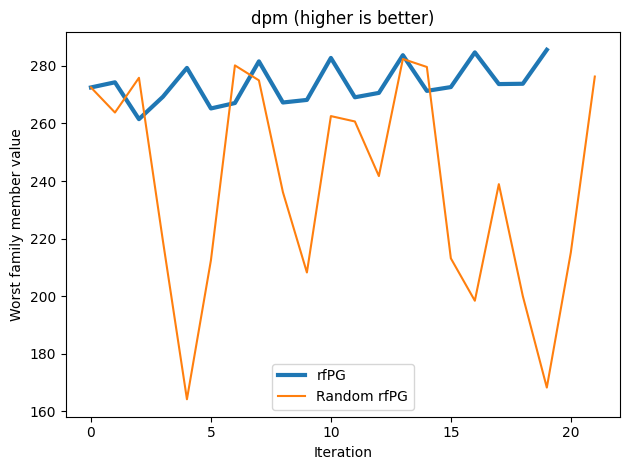

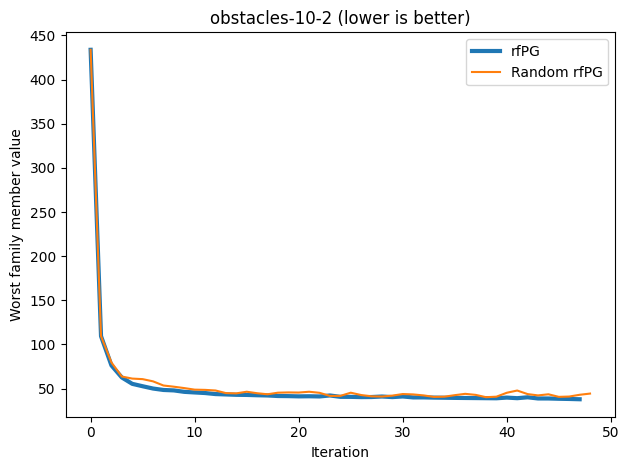

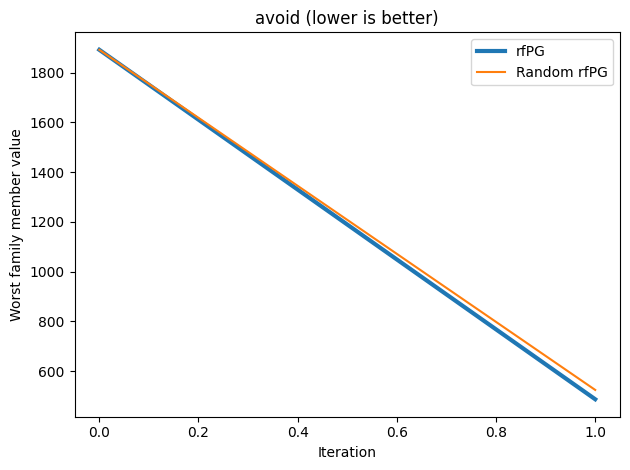

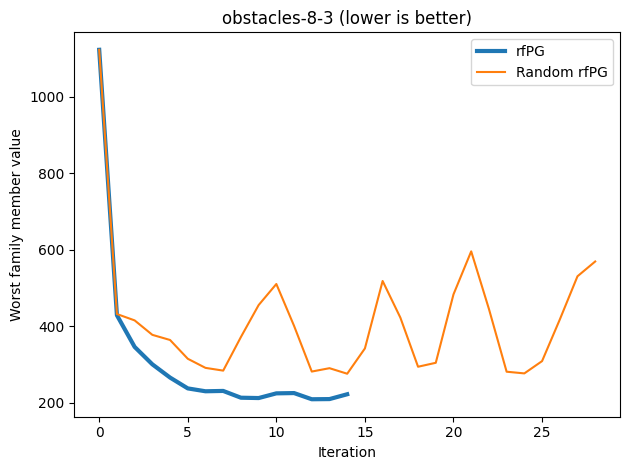

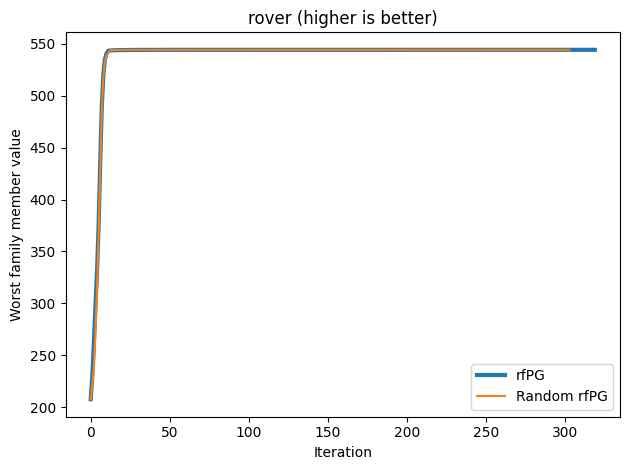

In [27]:
for env, minimizing in zip(['dpm', 'obstacles-10-2', 'avoid', 'obstacles-8-3', 'rover', 'network'], [False, True, True, True, False, False]):
    try:
        with open(f"{BASE_DIR}/{env}/gd-experiment.pickle", 'rb') as handle:
            results = pickle.load(handle)
            make_lineplot(results, title=env, minimizing=minimizing)
    except FileNotFoundError as fnfe:
        print(fnfe)

# DPM

timeout = 10s

In [30]:
dpm_our = [504.76099479, 496.6463078,  522.29707964, 471.26597349, 483.96767624,
 463.09737765, 294.67001291, 498.28841493, 510.35243059, 509.71750883]

In [31]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [32]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [33]:
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print(i, fsc.num_nodes)
    for j in range(fsc.num_nodes):
        print(fsc.update_function[j])

0 3
[{1: 1.0}, {1: 1.0}, {0: 1.0}]
[{2: 1.0}, {2: 1.0}, {0: 1.0}]
[{0: 1.0}, {0: 1.0}, {0: 1.0}]
1 3
[{0: 1.0}, {1: 1.0}, {0: 1.0}]
[{2: 1.0}, {1: 1.0}, {0: 1.0}]
[{1: 1.0}, {2: 1.0}, {0: 1.0}]
2 3
[{0: 1.0}, {1: 1.0}, {0: 1.0}]
[{2: 1.0}, {0: 1.0}, {0: 1.0}]
[{1: 1.0}, {2: 1.0}, {0: 1.0}]
3 3
[{1: 1.0}, {1: 1.0}, {0: 1.0}]
[{2: 1.0}, {2: 1.0}, {0: 1.0}]
[{0: 1.0}, {0: 1.0}, {0: 1.0}]
4 3
[{1: 1.0}, {2: 1.0}, {0: 1.0}]
[{0: 1.0}, {1: 1.0}, {0: 1.0}]
[{2: 1.0}, {0: 1.0}, {0: 1.0}]


In [34]:
with open(f"{BASE_DIR}/dpm/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [35]:
ours

{'ours': array([488.87356157, 293.70693161, 504.47945047, 400.67307925,
        464.31031754]),
 'whole_family': 286.81202013605287,
 'fsc': <paynt.quotient.fsc.FSC at 0x7fd17b4e1eb0>}

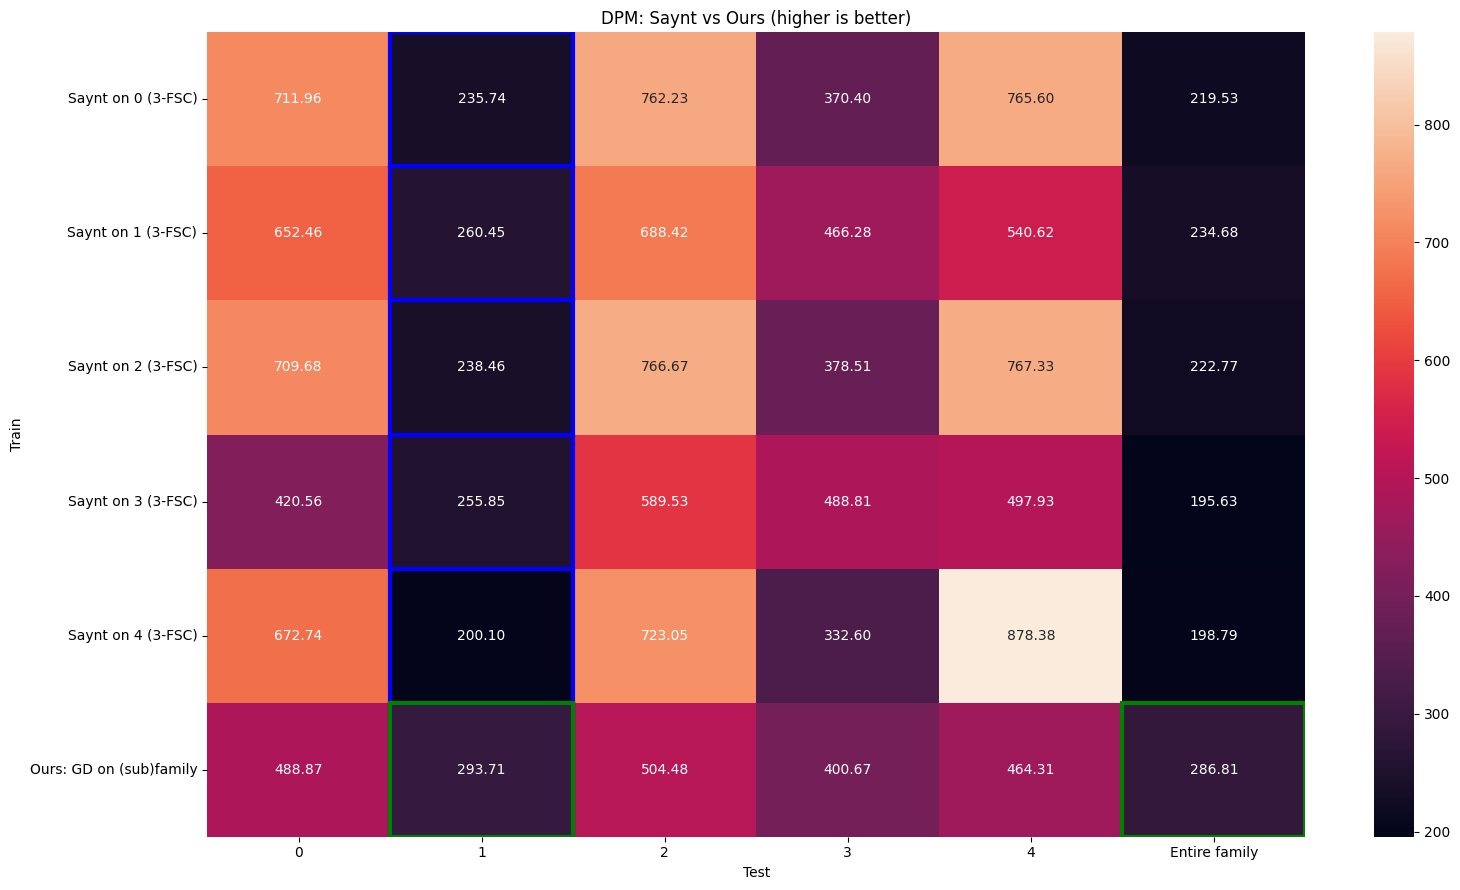

In [36]:
make_heatmap(subfamily_saynt_results, ours, "DPM", "Saynt", minimizing=False)

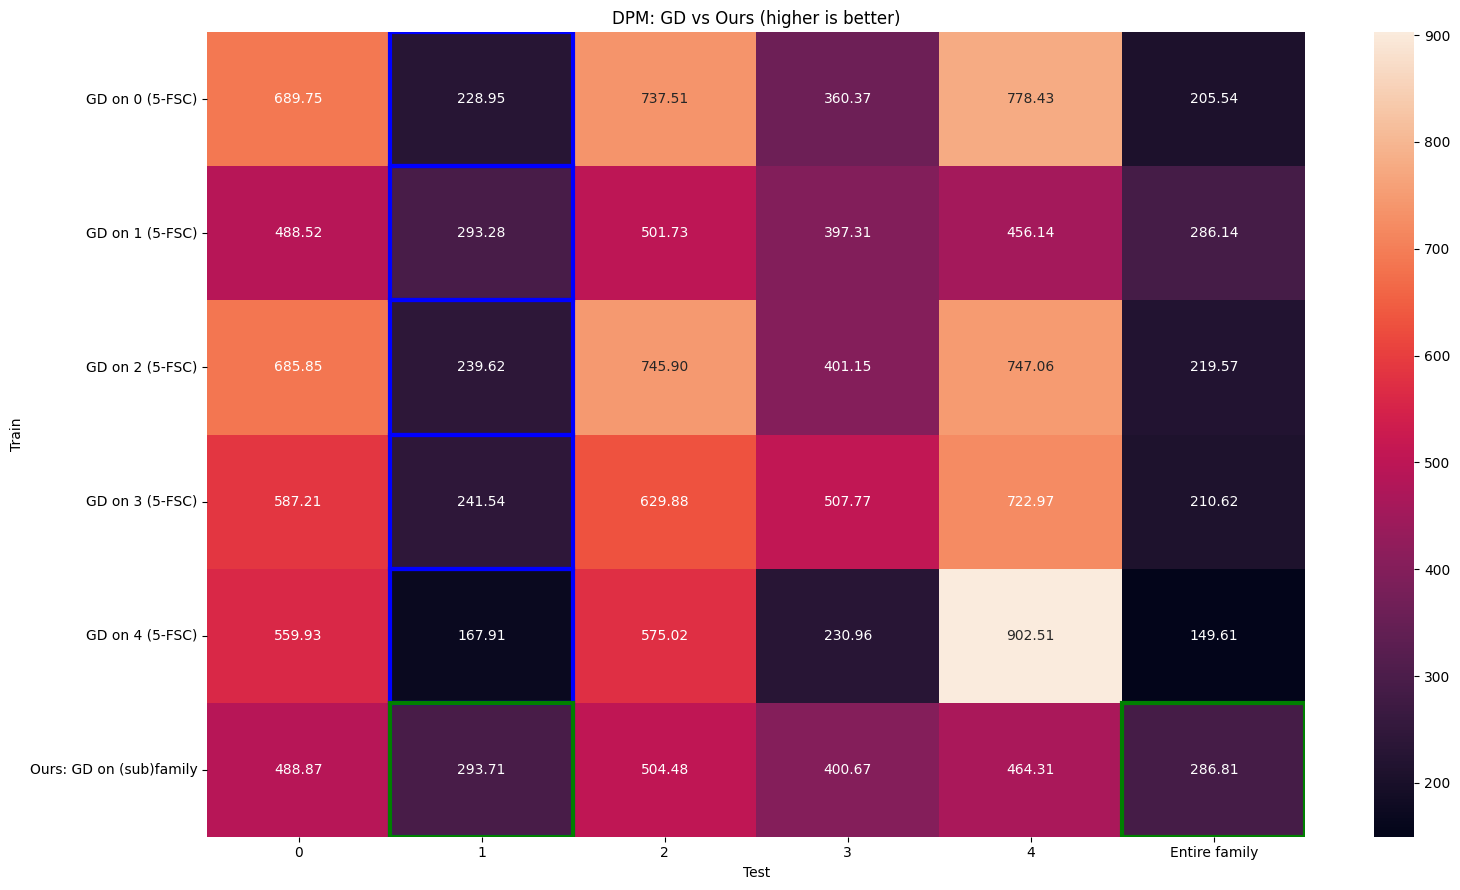

In [37]:
make_heatmap(subfamily_gd_results, ours, "DPM", "GD", minimizing=False)

# OBSTACLES 8 3

timeout = 30s

In [39]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    saynt = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: './output-new-bert/output-new/obstacles-8-3/5/saynt.pickle'

In [60]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    gradient = pickle.load(handle)

In [61]:
with open(f"{BASE_DIR}/obstacles-8-3/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: './output-new-bert/output-new/obstacles-8-3/5/ours.pickle'

In [ ]:
make_heatmap(saynt, ours, "OBSTACLES(8,3)", "Saynt")

## Gradient baseline

In [ ]:
make_heatmap(gradient, ours, "OBSTACLES(8,3)", "GD")

# OBSTACLES 10 2

timeout = 10s

In [40]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [41]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [42]:
print("Obstacles(10, 2):")
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print("POMDP", i, 'with a', f"{fsc.num_nodes}-FSC. Memory model:", fsc.memory_model)
    # for j in range(fsc.num_nodes):
        # print(fsc.update_function[j])
        # print("Node", j, [list(d.keys())[0] for d in fsc.update_function[j] if len(d) == 1])

Obstacles(10, 2):
POMDP 0 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
POMDP 1 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
POMDP 2 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
POMDP 3 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
POMDP 4 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]


In [43]:
with open(f"{BASE_DIR}/obstacles-10-2/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [44]:
ours_raw = [27.85853738, 28.71888006, 30.78940948, 28.75065993, 29.3297606,  30.77959397,
 29.48840814, 29.3297606,  28.22878829, 30.14997737]

In [45]:
ours

{'ours': array([31.24250074, 31.72967289, 38.29640731, 39.03028055, 36.62143647]),
 'whole_family': 39.03028054944415,
 'fsc': <paynt.quotient.fsc.FSC at 0x7fd0faf5c980>}

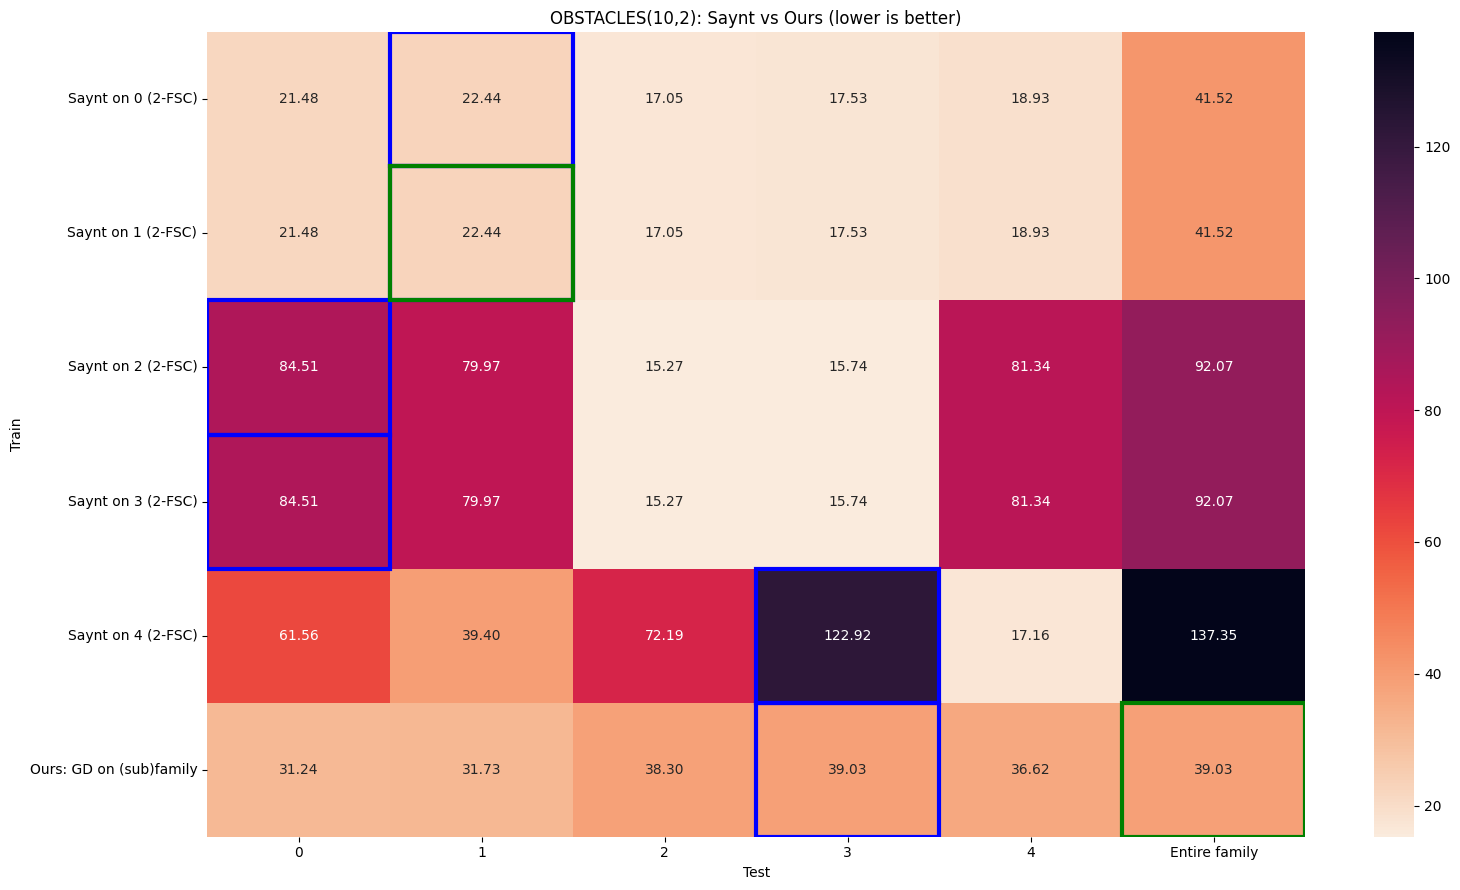

In [46]:
make_heatmap(subfamily_saynt_results, ours, "OBSTACLES(10,2)", "Saynt")

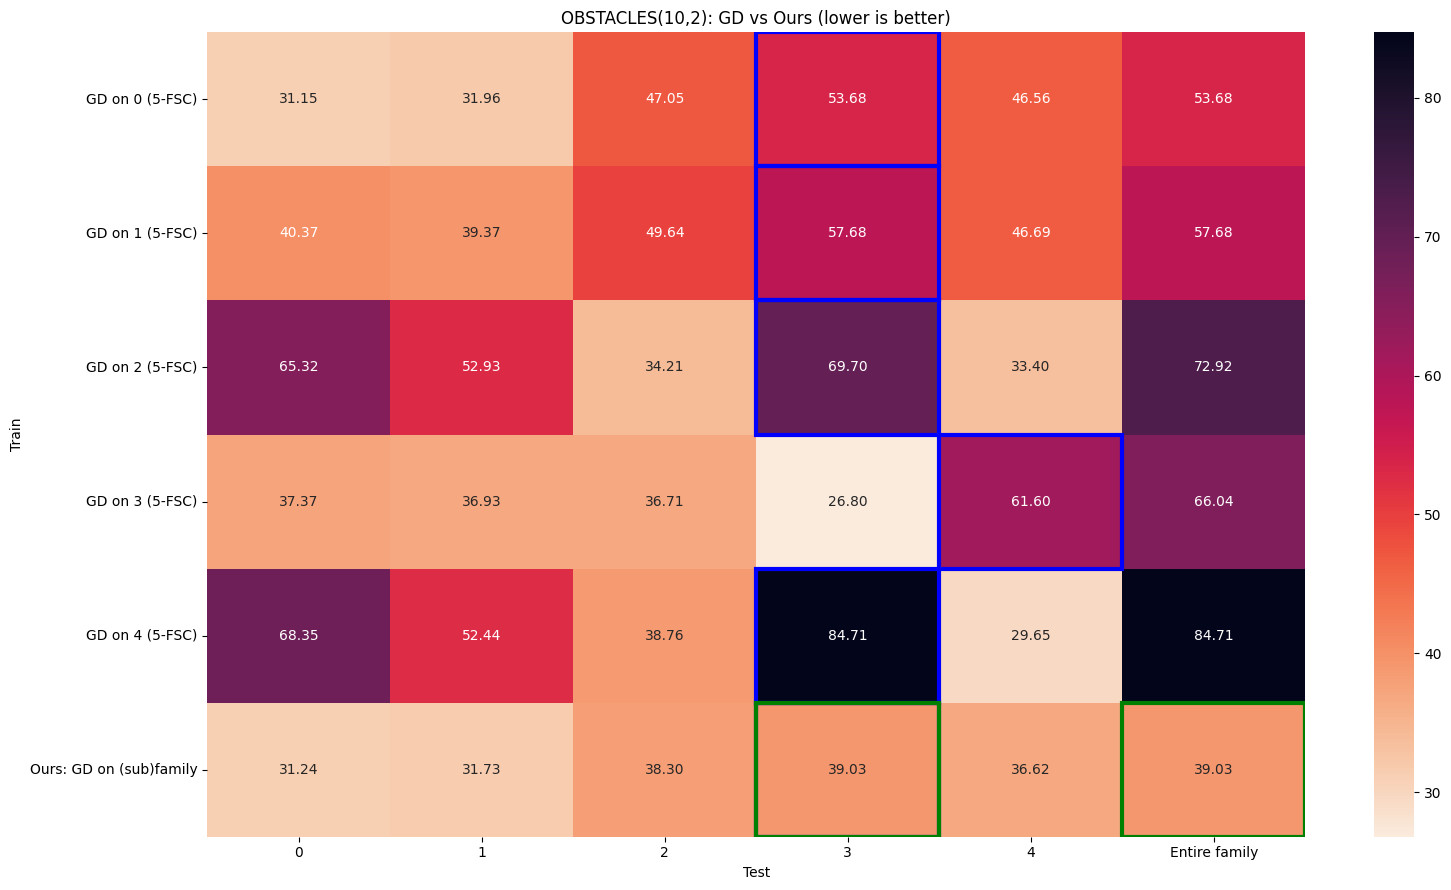

In [47]:
make_heatmap(subfamily_gd_results, ours, "OBSTACLES(10,2)", "GD")

# AVOID

timeout = 60s

In [48]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [49]:
ours

{'ours': array([127.55237893, 247.59945684, 191.44104576, 108.89654439,
        148.36875411]),
 'whole_family': 289.6115811240322,
 'fsc': <paynt.quotient.fsc.FSC at 0x7fd17bb1e420>}

In [50]:
# with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/paynt.pickle", 'rb') as handle:
#     subfamily_paynt_results = pickle.load(handle)

In [51]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/gradient.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [52]:
with open(f"{BASE_DIR}/avoid/{SUBFAMILY_SIZE}/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [53]:
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_gd_results[i][1]
    print(i, fsc.update_function)

0 [[{0: 0.244785245250107, 1: 0.4532642336017612, 2: 0.10041507781959003, 3: 0.04440138681063051, 4: 0.15713405651791112}, {0: 0.41577755529208726, 1: 0.041185816075274724, 2: 0.03811499531727658, 3: 0.2819997980248332, 4: 0.22292183529052828}, {0: 0.27397989639952386, 1: 0.03713338213525809, 2: 0.4479482119216168, 3: 0.05377848420324397, 4: 0.18716002534035722}, {0: 0.05010572990818707, 1: 0.14134135520113814, 2: 0.364453327847901, 3: 0.171896271197697, 4: 0.27220331584507684}, {0: 0.015458923632963719, 1: 0.5324948248974004, 2: 0.2917814037673371, 3: 0.057093036544493575, 4: 0.10317181115780516}, {0: 0.12901392891402433, 1: 0.335346787318109, 2: 0.07056204184268502, 3: 0.3513329082655243, 4: 0.11374433365965728}, {0: 0.374874886591899, 1: 0.045190836337549396, 2: 0.21371179855516223, 3: 0.29400656115680995, 4: 0.07221591735857931}, {0: 0.10316698105495366, 1: 0.26198683615774426, 2: 0.2499478004405938, 3: 0.19963268236632062, 4: 0.1852656999803877}, {0: 0.2751874977500867, 1: 0.20886

In [54]:
print("AVOID:")
for i in range(SUBFAMILY_SIZE):
    fsc = subfamily_saynt_results[i][1]
    print("POMDP", i, 'with a', f"{fsc.num_nodes}-FSC. Memory model:", fsc.memory_model)
    # for j in range(fsc.num_nodes):
        # print(fsc.update_function[j])
        # print("Node", j, [list(d.keys())[0] for d in fsc.update_function[j] if len(d) == 1])

AVOID:
POMDP 0 with a 5-FSC. Memory model: [1, 5, 1, 1, 1, 1, 5, 1, 1, 1, 1]
POMDP 1 with a 5-FSC. Memory model: [1, 5, 1, 1, 1, 1, 5, 1, 1, 1]
POMDP 2 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
POMDP 3 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
POMDP 4 with a 2-FSC. Memory model: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [55]:
l = [51.94674404, 65.42364497, 63.76348781, 98.68745545, 32.52550974, 67.09607064,
 87.41523619, 64.81453459, 53.95332456, 56.50783793]

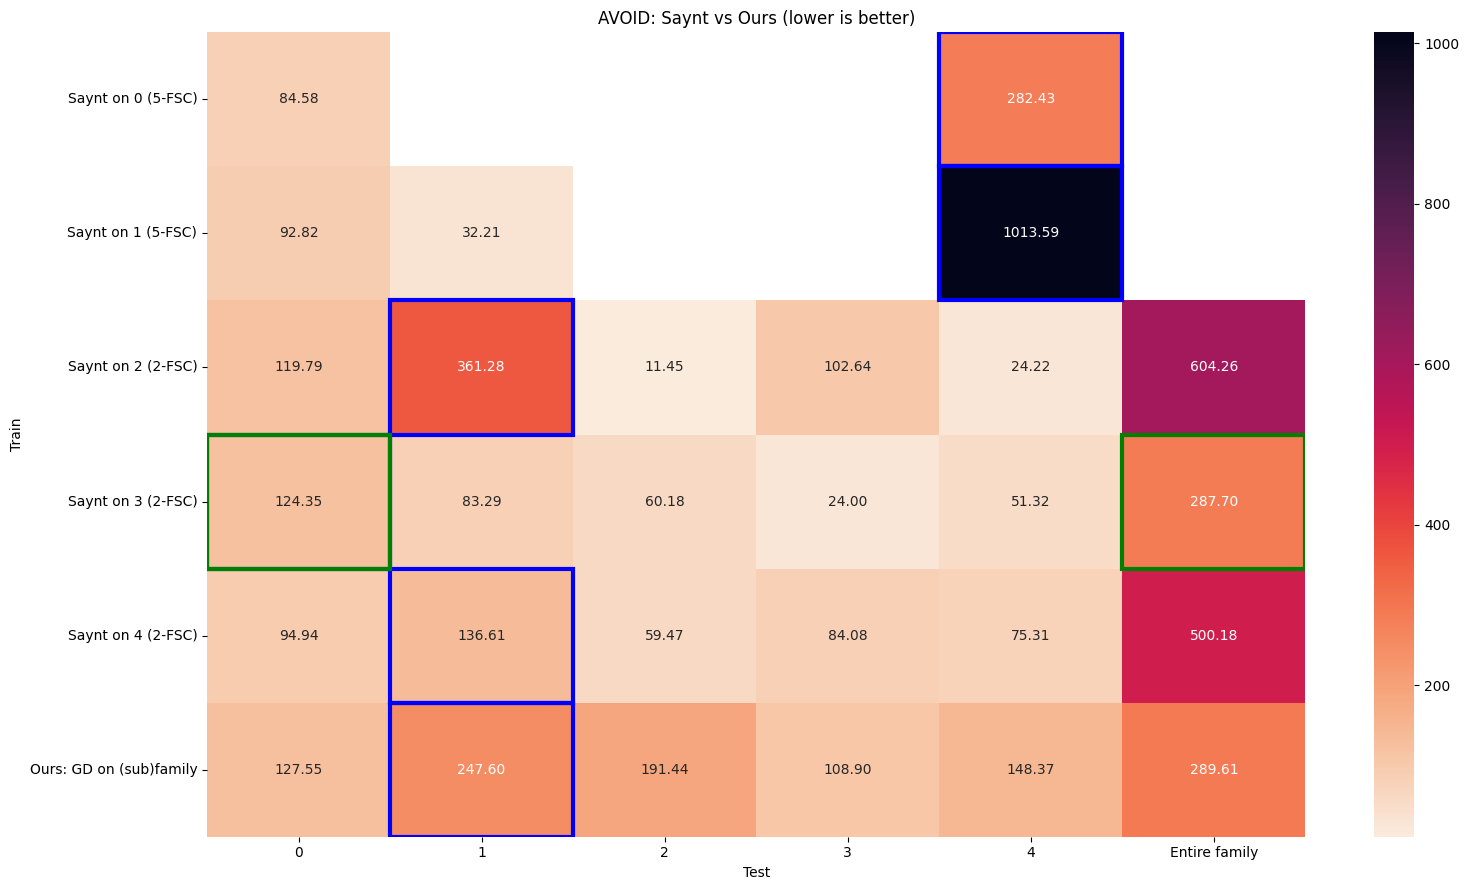

In [57]:
make_heatmap(subfamily_saynt_results, ours, "AVOID", "Saynt")

In [58]:
# make_heatmap(subfamily_paynt_results, ours, "AVOID", "Paynt")

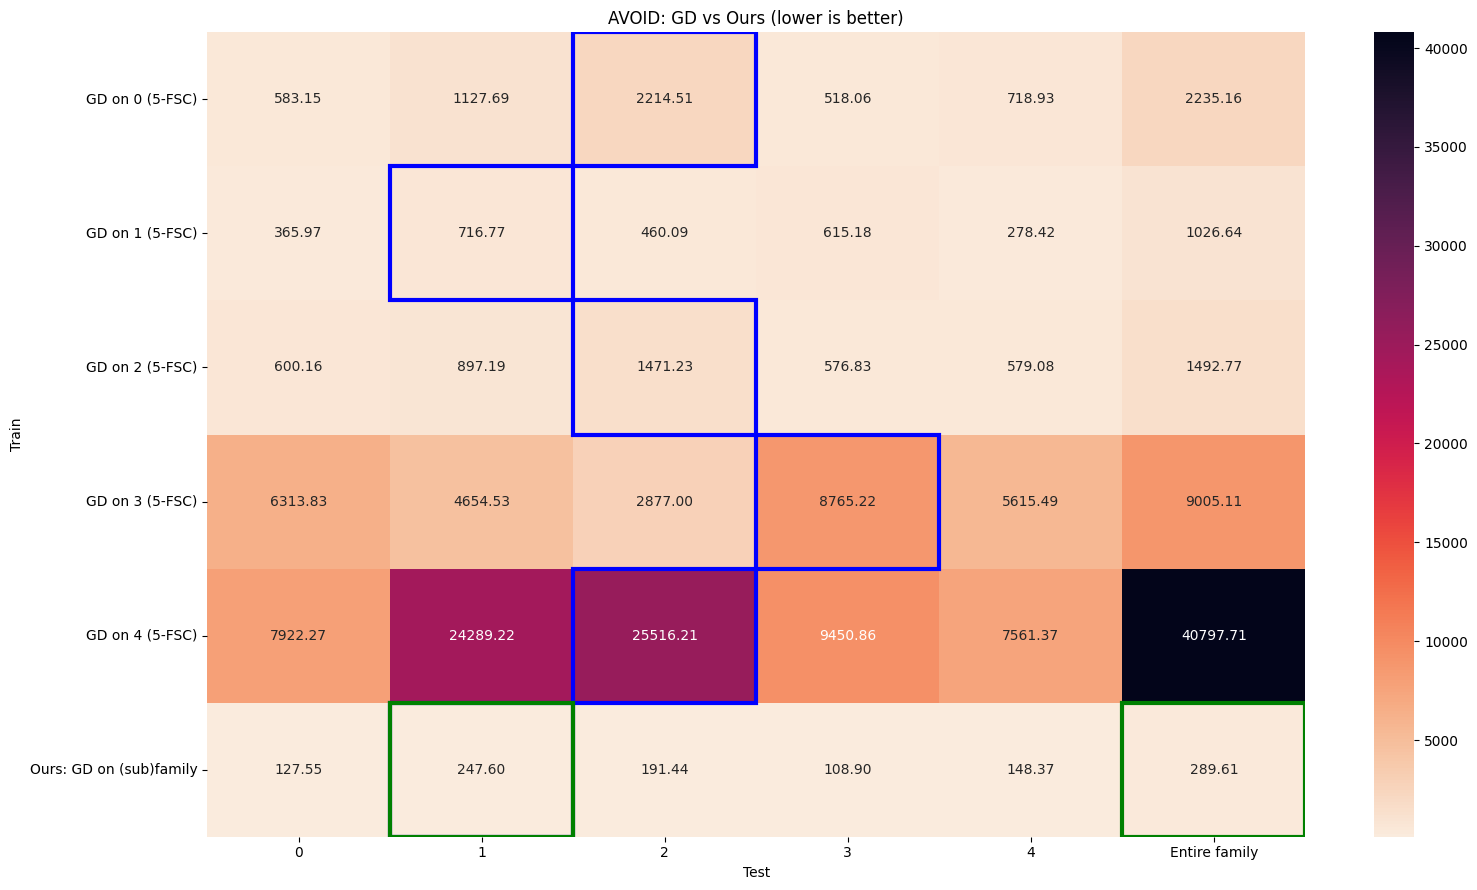

In [59]:
make_heatmap(subfamily_gd_results, ours, "AVOID", "GD")